In [29]:
%reload_ext autoreload
%autoreload 2

#note need to install transpile_benchy before running
#run 'pip install git+https://github.com/evmckinney9/transpile_benchy.git'

In [30]:
from transpile_benchy.interface import QASMBench
from transpile_benchy.interface import SubmoduleInterface
from transpile_benchy.metrics import MetricInterface
from typing import Iterator, List
from qiskit import QuantumCircuit
from qiskit.circuit.library import QuantumVolume

class QVInterface(SubmoduleInterface):
    """Abstract class for a submodule for quantum volume"""

    def get_quantum_circuits(self) -> Iterator[QuantumCircuit]:
        """Return an iterator over QuantumCircuits."""
        for q in self.rangeQ:
            yield QuantumVolume(num_qubits=q, depth=q)

    def estimate_circuit_count(self) -> int:
        return len(self.rangeQ)

class QVBench(QVInterface):
    """Submodule for QASMBench circuits."""

    def __init__(self, size: str):
        """Initialize QASMBench submodule.

        size: 'small', 'medium', or 'large'
        small is [4, 6, 8, 10, 12, 14, 16]
        """
        self.size = size
        if size == 'small':
            self.rangeQ = range(4, 64, 8) #specifies the range of qubits traversed
        else:
            self.rangeQ = range(4, 64, 8)

class TotalMetric(MetricInterface):
    """Calculate the total 2Q gate count of a circuit."""

    def __init__(self):
        """Initialize the metric."""
        self.name = "Total Gates"

    @staticmethod
    def calculate(circuit: QuantumCircuit) -> float:
        """Calculate the depth of a circuit."""
        # dumb way :)
        from qiskit.converters import circuit_to_dag
        dag = circuit_to_dag(circuit)
        return len(dag.two_qubit_ops())
        # # return circuit.depth(filter_function=lambda x: x[0].name not in exclude_gates)
        # total_cx_count = circuit.count_ops()["cx"]
        # critcal_path_cx_count = circuit.depth(filter_function=lambda x : len(x.qargs) != 2)

qasm_bench = QASMBench(size="small")

qv_bench = QVBench(size = "small")

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()
total_metric = TotalMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

In [31]:
from transpile_benchy.runner import CustomPassManager
from qiskit.transpiler.passes import (
    DenseLayout,
    LookaheadSwap,
    TrivialLayout,
    BasicSwap,
    SabreLayout,
    SabreSwap,
)
from qiskit.transpiler.passes import (
    ApplyLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)


class Trivial_Basic(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                TrivialLayout(self.coupling),
                FullAncillaAllocation(self.coupling),
                EnlargeWithAncilla(),
                ApplyLayout(),
                BasicSwap(self.coupling),
            ]
        )


# class Dense_Lookahead(CustomPassManager):
#     def main_process(self, circuit):
#         """Process the circuit."""
#         self.main_pm.append(
#             [
#                 DenseLayout(coupling_map),
#                 FullAncillaAllocation(coupling_map),
#                 EnlargeWithAncilla(),
#                 ApplyLayout(),
#                 LookaheadSwap(coupling_map),
#             ]
#         )
#         return self.main_pm.run(circuit)


class SABRE(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                SabreLayout(self.coupling),
                # FullAncillaAllocation(coupling_map),
                # EnlargeWithAncilla(),
                # ApplyLayout(),
                SabreSwap(self.coupling),
            ]
        )



In [32]:
from qiskit import transpile
from abc import abstractmethod
from transpile_benchy.runner import AbstractRunner

class QiskitTranspileRunner(AbstractRunner):
    """used to noop the pre-, main-, post- passes"""
    def pre_process(self):
        pass
    
    def main_process(self):
        pass
    def post_process(self):
        pass

    @abstractmethod
    def run(self):
        """Abstract method for overloaded run method."""
        pass


class corral(QiskitTranspileRunner):
    def __init__(self, coupling_map, name:str=None):
        super().__init__(name=name)
        self.coupling_map = coupling_map
    def run(self, qc):
        return transpile(qc, coupling_map=self.coupling_map, optimization_level=3, basis_gates=["cx", "u"])

In [33]:
def snail_to_connectivity(snail_edge_list):
    # Convert snail edge list where nodes are snails and edges are qubits
    # To connectivity edge list where nodes are qubits and edges are coupling
    edge_list = []

    # qubits are coupled to a snail edge if they are both adjacent to a snail node
    for qubit, snail_edge in enumerate(snail_edge_list):
        for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
            if qubit != temp_qubit and (
                snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
            ):
                edge_list.append((qubit, temp_qubit))
    return edge_list

# define corral
def corral_skip( num_snails=32, num_levels=2, level_1_skip=1, level_2_skip=1):
    """Returns edge list of a corral of size specified snails are nodes,
    edges are qubits."""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(1, num_levels + 1):
            if i == 1:
                snail_edge_list.append(
                    ((snail0 + level_1_skip) % num_snails, snail0)
                )
            elif i == 2:
                snail_edge_list.append(
                    (snail0, (snail0 + level_2_skip) % num_snails)
                )
    return snail_edge_list

In [34]:
from qiskit.transpiler.coupling import CouplingMap

input_corrals = {}
N = 32 #N is number of snails 2*N is number of qubits
first = 1
for i in range(0, 64, 2):
    name = f'corral_N_{N}_({first}_{i})'
    input_corrals[i] =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=i)))


In [35]:
from logging import Logger
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot( b=None, save=False):
    """Plot benchmark results.
    b is the bencmark instance, needed to overwrite plot func in class w/o changing source code"""
    with plt.style.context("seaborn-darkgrid"):
        bar_width = 0.35
        transpiler_count = len(b.transpilers)

        # Define color palette, may need to add more colors in data exceeds current number of colors
        colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                  '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                  "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                  "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]


        # Loop over metrics
        for metric_name, results in benchmark.results.items():
            labels = []
            plotlines = {} #x y info for each corral
            
            fig, ax = plt.subplots()
            qubits = benchmark.submodules[0].rangeQ
            # Create a line for each circuit
            for i, (circuit_name, circuit_results) in enumerate(results.items()):
                # Create a line for each qubit at different corral connection patterns
                for j, transpiler_result in enumerate(circuit_results):
                    if qubits[i] not in labels: #transpiler result is str of corral name
                        labels.append(qubits[i])
                    # ax.scatter(qubits[i], circuit_results[transpiler_result], c = colors[j%len(colors)], label = transpiler_result,linewidth=2.0)
                    if qubits[i] in plotlines:
                        plotlines[qubits[i]][0].append(int(transpiler_result ))
                        plotlines[ qubits[i]][1].append(circuit_results[transpiler_result] )
                    else:
                        plotlines[qubits[i]] = [[ int(transpiler_result) ], [circuit_results[transpiler_result] ]] 
                        #each line for different qubit, x is corral, y is depth

            max_height = 0
            max_x = 0
            plt.figure(figsize=(15,10))
            for i, c in enumerate(plotlines):
                plt.plot(plotlines[c][0], plotlines[c][1], marker = 'o', color = colors[i])
                if max(plotlines[c][1]) > max_height:
                    max_height = max(plotlines[c][1])
                if max(plotlines[c][0]) > max_x:
                    max_x = max(plotlines[c][0])

            # Add labels, title, etc
            plt.xlabel("Skip connections (1,x)")
            plt.ylabel(metric_name)
            # subtitle Best of N={self.num_runs} runs
            plt.title(
                f"Transpiler {metric_name} Comparison,\
                        Best of N={benchmark.num_runs} runs"
            )

            max_fontsize = 10
            min_fontsize = 4
            font_size = max(min(max_fontsize, 800 // len(results)), min_fontsize)

            ax.set(xlim=(0, max_x+2), xticks=np.arange(1, max_x+2, 5),
            ylim=(0, max_height+10), yticks=np.arange(1, max_height+10, 500))
            plt.legend(labels)


            # Show the plot
            plt.show()
            # # Create figure for each metric
            # plt.figure(figsize=(10, 6))
            # #bar graph  
            # # Create a bar for each circuit
            # for i, (circuit_name, circuit_results) in enumerate(results.items()):
            #     circuit_results = list(circuit_results.values())
            #     # Create a bar for each transpiler
            #     for j, transpiler_result in enumerate(circuit_results):
            #         plt.bar(
            #             i * transpiler_count + j * bar_width,
            #             transpiler_result,
            #             width=bar_width,
            #             color=colors[
            #                 j % len(colors)
            #             ],  # choose color based on transpiler index
            #             label=f"{b.transpilers[j].name}"
            #             if i == 0
            #             else "",  # avoid duplicate labels
            #         )

            # # Set x-ticks labels once for each metric
            # plt.xticks(
            #     np.arange(len(results)) * transpiler_count
            #     + bar_width * (transpiler_count - 1) / 2,
            #     results.keys(),
            #     rotation="vertical",
            #     fontsize=font_size,
            # )

            if save:
                plt.savefig(f"transpile_benchy_{metric_name}.svg", dpi=300)


In [36]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)
transpilersCorral = []
for c in input_corrals:
    transpilersCorral.append(corral(input_corrals[c], name =str(c))) #name is number of skipped qubits in connections connection would be (1,c)

benchmark = Benchmark(
    transpilers=transpilersCorral,
    submodules=[qv_bench],
    metrics=[depth_metric, total_metric],
    logger = transpile_benchy_logger,
)
benchmark.run()
plot(b = benchmark, save=True)

c name : 0
c name : 2
c name : 4
c name : 6
c name : 8
c name : 10
c name : 12
c name : 14
c name : 16
c name : 18
c name : 20
c name : 22
c name : 24
c name : 26
c name : 28
c name : 30
c name : 32
c name : 34
c name : 36
c name : 38
c name : 40
c name : 42
c name : 44
c name : 46
c name : 48
c name : 50
c name : 52
c name : 54
c name : 56
c name : 58
c name : 60
c name : 62


Running circuits for QVBench:  25%|██▌       | 2/8 [02:53<09:55, 99.32s/it]

<Figure size 640x480 with 0 Axes>

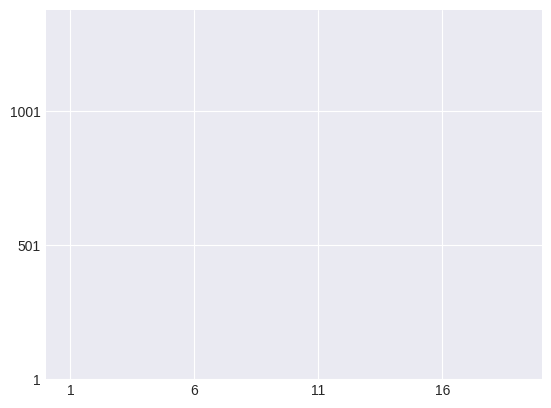

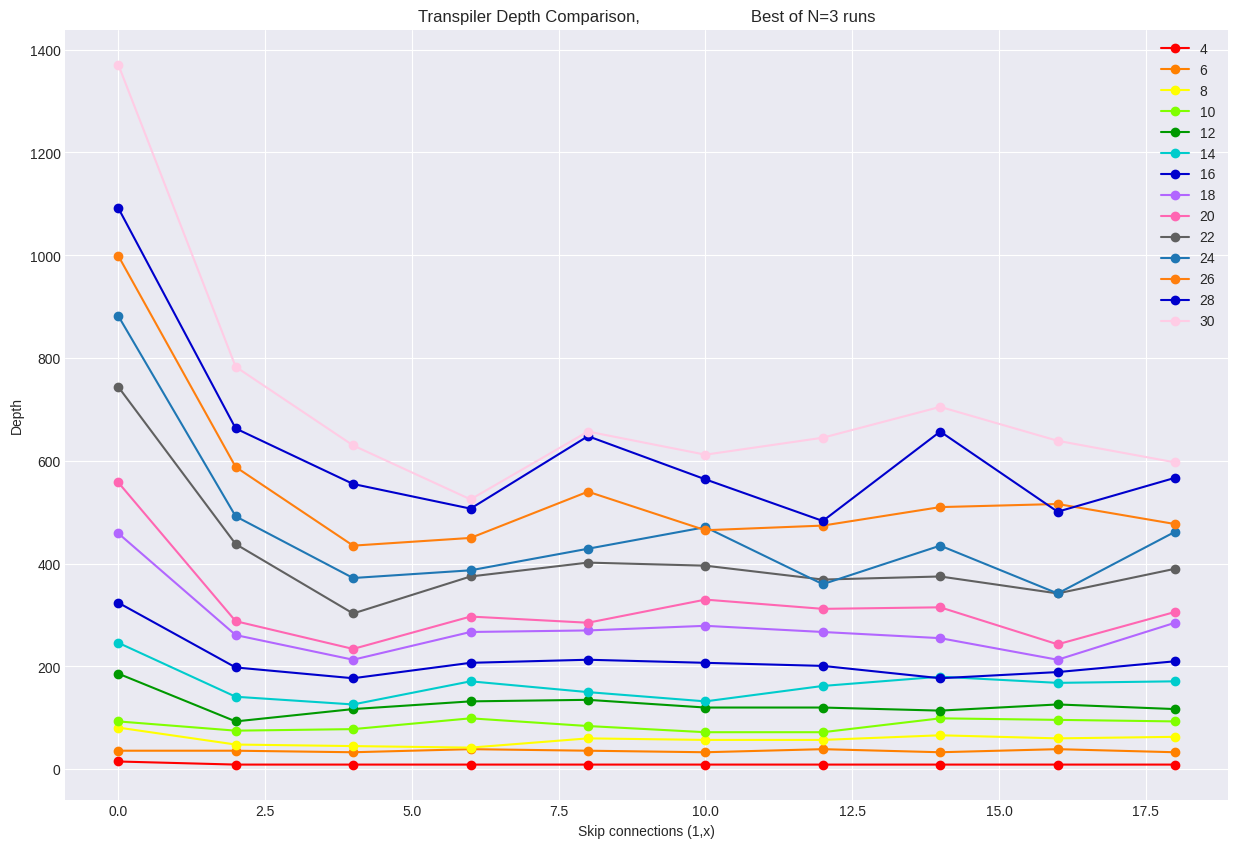

<Figure size 640x480 with 0 Axes>

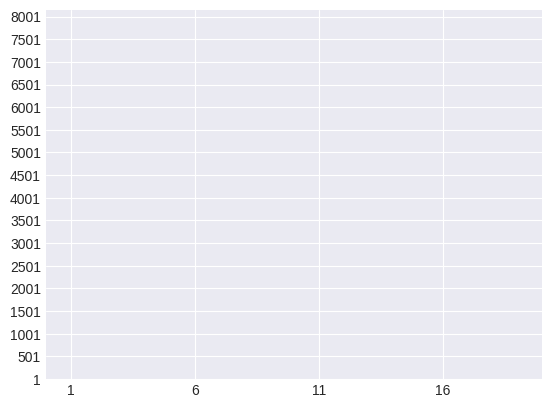

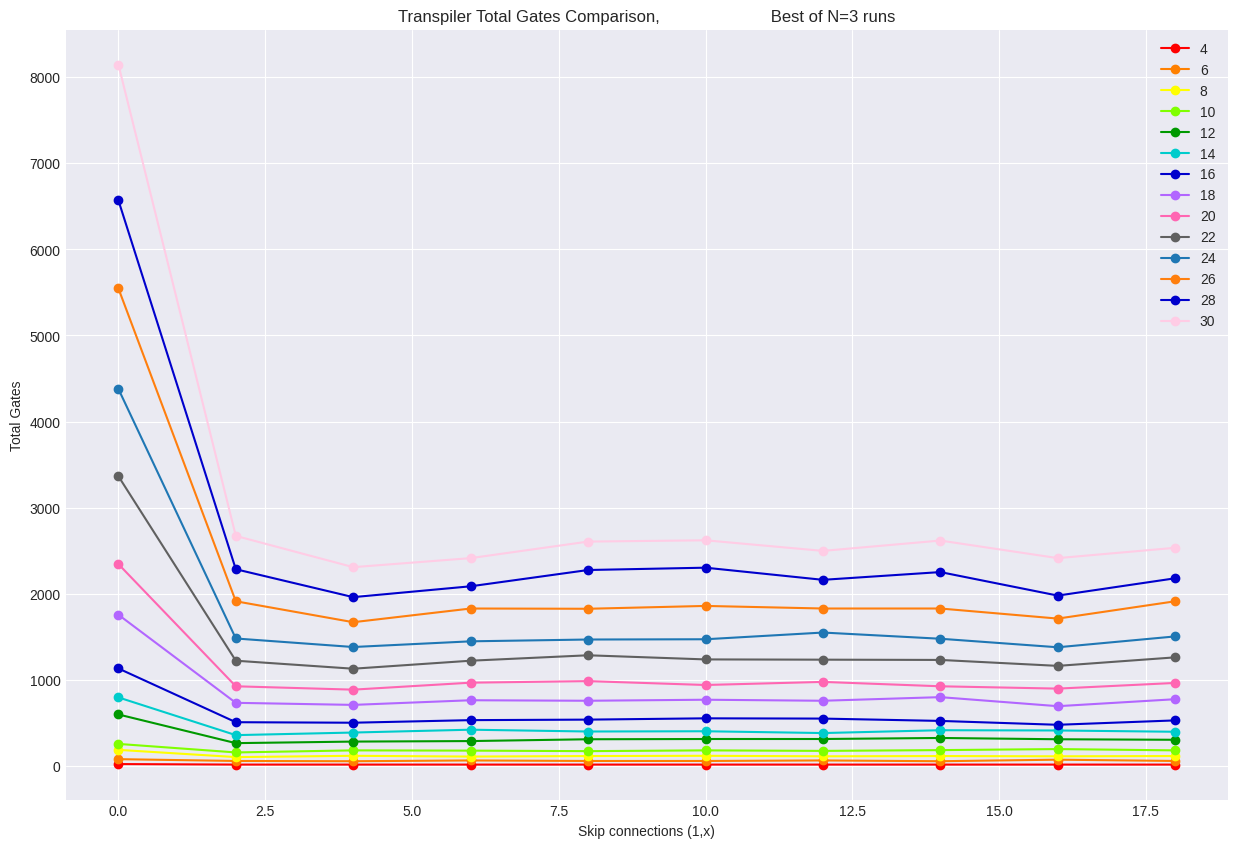

In [27]:
plot(b = benchmark, save=True)